# **Introduction**

Dataset used for this project was sourced from: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

Data includes 45000 records of loan approvals which includes features such as age, gender, income, loan amount etc.

Data includes one target variable, loan_status which reveals whether the loan was approved or not (binary classification).

# **Objective**

We're trying to solve problem of predicting, classifying prediction of loan status. Approved - 1 or Not Approved - 0.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

# **1. Basic Data Cleaning and Creating Train/Test Split**
### **1.1 Reading in the data and inspection**

In [25]:
raw_data = pd.read_csv('loan_data.csv')

# Create new copy of data
data = raw_data.copy()

pd.set_option('display.max_columns', None)
raw_data.tail()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1
44999,24.0,male,High School,51609.0,1,RENT,6665.0,DEBTCONSOLIDATION,17.05,0.13,3.0,628,No,1


### **1.2 Basic Data Cleaning**
We'll start by renaming the columns to make them more descriptive of what we're trying to work with



In [26]:
# Define updated column names
new_columns = {
    'person_age': 'age',
    'person_gender': 'gender',
    'person_education': 'education',
    'person_income': 'income',
    'person_emp_exp': 'years_employed',
    'person_home_ownership': 'home_owner',
    'loan_amnt': 'loan',
    'loan_intent': 'intent',
    'loan_int_rate': 'loan_interest_rate',
    'loan_percent_income': 'loan_percent_income',
    'cb_person_cred_hist_length': 'credit_history',
    'credit_score': 'credit_score',
    'previous_loan_defaults_on_file': 'loan_defaults',
    'loan_status': 'loan_status'
}

# Updating them
data.rename(columns = new_columns, inplace = True)
data.tail()

,age,gender,education,income,years_employed,home_owner,loan,intent,loan_interest_rate,loan_percent_income,credit_history,credit_score,loan_defaults,loan_status
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1
44999,24.0,male,High School,51609.0,1,RENT,6665.0,DEBTCONSOLIDATION,17.05,0.13,3.0,628,No,1


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45000 non-null  float64
 1   gender               45000 non-null  object 
 2   education            45000 non-null  object 
 3   income               45000 non-null  float64
 4   years_employed       45000 non-null  int64  
 5   home_owner           45000 non-null  object 
 6   loan                 45000 non-null  float64
 7   intent               45000 non-null  object 
 8   loan_interest_rate   45000 non-null  float64
 9   loan_percent_income  45000 non-null  float64
 10  credit_history       45000 non-null  float64
 11  credit_score         45000 non-null  int64  
 12  loan_defaults        45000 non-null  object 
 13  loan_status          45000 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 4.8+ MB


Checking for duplicated and NaN values

In [28]:
# Check for duplicated values
print(data.duplicated().sum(), 'duplicated values.\n')

# Check for NaN values
print('Null values per column: \n')
print(data.isna().sum())

0 duplicated values.

Null values per column: 

age                    0
gender                 0
education              0
income                 0
years_employed         0
home_owner             0
loan                   0
intent                 0
loan_interest_rate     0
loan_percent_income    0
credit_history         0
credit_score           0
loan_defaults          0
loan_status            0
dtype: int64


### **1.3 Create Train/Test Split**

Since no test set has been provided, we'll hold out a portion of the data as our test set.

Let's first see the distribution for claim values to help define the number and width of bins we should use:

<Axes: xlabel='loan', ylabel='Count'>

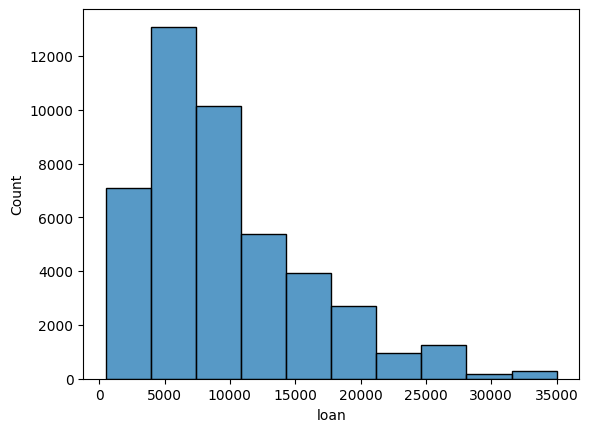

In [29]:
# Create histogram for loan values
sns.histplot(data['loan'], bins = 10)

Feature is skewed right. It would most likely be the best if we're to use non-linearly spaced bins to capture the more extreme values with few instances.

In [30]:
# Define bins
bins = [0.0, 6000, 12_000, 18_000, 24_000, np.inf]

# Define bin labels
labels = np.arange(1, 6)

# Apply the bins using cut
data['loan_category'] = pd.cut(data['loan'], bins = bins, labels = labels, include_lowest = True)

We can now see the distribution of our loan_category categories by creating a barplot

<Axes: ylabel='loan_category'>

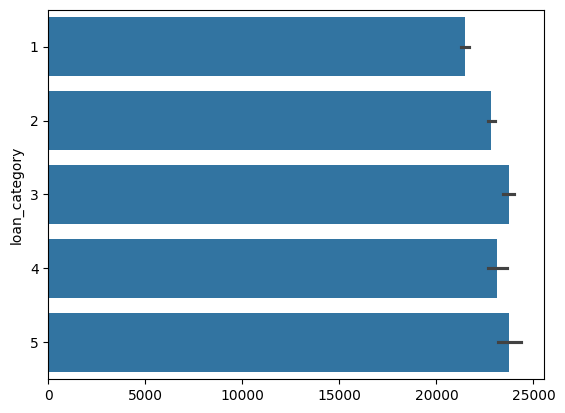

In [31]:
sns.barplot(data['loan_category'])

Distribution looks fine, let's proceed with creating the split.

In [32]:
# Create clean copy of training data
X = data.copy()
y = data['loan_status']

# Drop target features
X.drop(columns = ['loan_status','loan'], axis = 1, inplace = True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 14, stratify = X['loan_category'])

Let's compare the distribution of positive/negative class for loan_status in the y_train and y_test classes:

In [33]:
train_ratio = round((y_train.sum()/len(y_train))*100, 2)
test_ratio = round((y_test.sum()/len(y_test))*100, 2)

print(f'Train positive class ratio: {train_ratio}%')
print(f'Test positive class ratio: {test_ratio}%')

Train positive class ratio: 22.16%
Test positive class ratio: 22.49%


Looks like a perfect split, let's drop the loan_category column from our X_train and X_test sets:

In [34]:
for set_ in (X_train, X_test):
  set_.drop(columns = ['loan_category'], axis = 1, inplace = True)

# **2. Exploratory Data Analysis (EDA)**
### **Preparation**
For the purpose of our EDA, we'll join X_train and y_train to investigate correlation.

In [35]:
# Create a new copy of X_train for the analysis
eda = X_train.copy()
eda['loan'] = y_train

Let's check how many unique values we've got in each column

In [36]:
eda_columns = eda.columns

for col in eda_columns:
  col_values = eda[col].nunique()
  print(col, '|', col_values, '|', col_values < 10)

age | 59 | False
gender | 2 | True
education | 5 | True
income | 28437 | False
years_employed | 61 | False
home_owner | 4 | True
intent | 6 | True
loan_interest_rate | 1275 | False
loan_percent_income | 64 | False
credit_history | 29 | False
credit_score | 336 | False
loan_defaults | 2 | True
loan | 2 | True


For the purpose of our EDA, we'll update 'male/female' and 'Yes/No' features to binary so we can see if those values correlate somehow aswell.

In [37]:
# Define binary columns
binary_cols = ['gender', 'loan_defaults']

# Define map values
mapping = {'male': 1,
           'female': 0,
           'Yes': 1,
           'No': 0}

# Define function to binarise features
def binarise(data, cols, map):
  for col in cols:
    data[col] = data[col].map(map)
  return data

# Call function and print top 5 rows
eda_data = binarise(eda, binary_cols, mapping)
eda_data.head()

,age,gender,education,income,years_employed,home_owner,intent,loan_interest_rate,loan_percent_income,credit_history,credit_score,loan_defaults,loan
44061,23.0,1,High School,58589.0,0,RENT,PERSONAL,10.57,0.08,3.0,543,0,1
40989,26.0,1,Associate,145045.0,3,RENT,EDUCATION,9.83,0.17,3.0,674,0,0
29751,40.0,0,Associate,141759.0,17,RENT,HOMEIMPROVEMENT,11.14,0.07,13.0,638,1,0
9081,23.0,1,Bachelor,72990.0,2,RENT,VENTURE,11.14,0.11,3.0,656,0,0
12177,22.0,1,High School,30519.0,0,RENT,PERSONAL,9.63,0.39,3.0,669,0,1


### **2.2 Correlation Matrix**
As there are many features, let's create a correlation matrix from just our loan target feature.

In [38]:
eda_data.corr(numeric_only = True).sort_values(by = 'loan', ascending = False)

,age,gender,income,years_employed,loan_interest_rate,loan_percent_income,credit_history,credit_score,loan_defaults,loan
loan,-0.022173,-0.006781,-0.131385,-0.021132,0.331860,0.382372,-0.012699,-0.003752,-0.542881,1.000000
loan_percent_income,-0.040324,-0.002390,-0.226099,-0.037243,0.125261,1.000000,-0.027853,-0.008239,-0.202054,0.382372
loan_interest_rate,0.010217,0.003790,-0.000608,0.013157,1.000000,0.125261,0.015522,0.010096,-0.179768,0.331860
credit_score,0.180886,0.001032,0.039024,0.188175,0.010096,-0.008239,0.157259,1.000000,-0.184318,-0.003752
gender,0.017231,1.000000,0.010183,0.015402,0.003790,-0.002390,0.011131,0.001032,0.004374,-0.006781
credit_history,0.861688,0.011131,0.121421,0.824597,0.015522,-0.027853,1.000000,0.157259,-0.027545,-0.012699
years_employed,0.954921,0.015402,0.195033,1.000000,0.013157,-0.037243,0.824597,0.188175,-0.031710,-0.021132
age,1.000000,0.017231,0.202265,0.954921,0.010217,-0.040324,0.861688,0.180886,-0.028003,-0.022173
income,0.202265,0.010183,1.000000,0.195033,-0.000608,-0.226099,0.121421,0.039024,0.058253,-0.131385
loan_defaults,-0.028003,0.004374,0.058253,-0.031710,-0.179768,-0.202054,-0.027545,-0.184318,1.000000,-0.542881


We'll use Seaborn here to create a single column heatmap plot sorted by correlation value.

<Axes: >

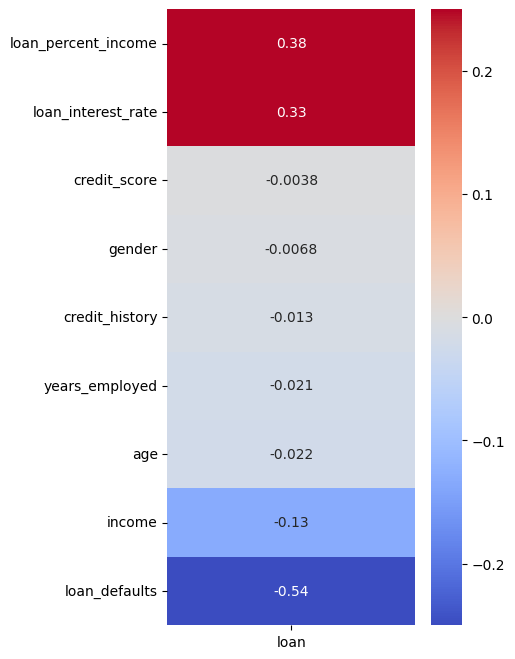

In [39]:
fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix = eda_data.corr(numeric_only=True).sort_values(by='loan',ascending=False)
corr_matrix_no_loan = corr_matrix.drop('loan')

sns.heatmap(corr_matrix_no_loan[['loan']],cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

Observations:



*   Features such as percentage of income as loan and loan interest rate are showing strong positive correlation:

  *   Percentage of income as loan having a high correlation would mean that oftentimes loans are approved or denied based on the ratio of income/loan
  *   Loan interest rate having a high correlation doesn't necessarily have to mean it's affecting approval or denial directly, it could mean that other features are rallying this number up

*  Features with strong negative correlation such as loan_defaults:

  *   As the likelihood of default increases, likelihood of loan approval decreases - or to put it simply, applicants who are more likely to default on their loans are significantly less likely to get approved

*   Features with negligible correlation:
  *   All the other features colored gray-ish have negligible correlation, it may be beneficial to our model to drop some of these to reduce the number of features passed to the models







# **3. Data Cleaning and Preprocessing**
### **3.1 Dropping Features**
We'll start by dropping the 'gender' feature as this showed next to no correlation with target variable

In [94]:
numerical_cols = ['age', 'income', 'years_employed',
                      'loan_interest_rate', 'loan_percent_income',
                      'credit_history', 'credit_score']

X_train_raw = X_train.copy()

cols_dropped = ['gender']

X_train_raw.drop(columns = cols_dropped, axis = 1, inplace = True)

### **3.2 Categorical Feature Encoding**
We can now consider how we will encode the categorical features so that they can be used with machine learning algorithms.

Let's split the columns into two lists, one for ordinal encoder (the one that's rank affected) and one for one-hot encoder.

In [41]:
# Define ordinal features
cat_cols_ord = ['education']

# Define one-hot features
cat_cols_onehot = ['home_owner', 'intent', 'loan_defaults']

education_rank = [['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']]

Let's create encoders for each feature type

In [42]:
# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories = education_rank)

# Define one-hot encoder
one_hot_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)

We can now encode the values using fit_transform and return these values to a DataFrame to check the encoding:

In [43]:
# Create dfs for each array
ord_encoded = ord_encoder.fit_transform(X_train_raw[cat_cols_ord])
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = cat_cols_ord

one_hot_encoded = one_hot_encoder.fit_transform(X_train_raw[cat_cols_onehot])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

In [44]:
# Join encoded dfs to a single df and show top 5 rows
all_cat_encoded_df = pd.concat([ord_encoded_df, one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,education,home_owner_MORTGAGE,home_owner_OTHER,home_owner_OWN,home_owner_RENT,intent_DEBTCONSOLIDATION,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE,loan_defaults_No,loan_defaults_Yes
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


We can now join our encoded features back with the numerical features to give us our pre-processed data

In [45]:
X_train_raw['loan_defaults'] = eda_data['loan_defaults']
X_train_raw = X_train_raw[numerical_cols].reset_index(drop = True)

all_cat_encoded_df = all_cat_encoded_df.reset_index(drop = True)

# Join numerical and categorical data
X_train_df = pd.concat([df.reset_index(drop = True) for df in [X_train_raw, all_cat_encoded_df]], axis = 1)

# Check the values
X_train_df.head()

,age,income,years_employed,loan_interest_rate,loan_percent_income,credit_history,credit_score,loan_defaults,education,home_owner_MORTGAGE,home_owner_OTHER,home_owner_OWN,home_owner_RENT,intent_DEBTCONSOLIDATION,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE,loan_defaults_No,loan_defaults_Yes
0,23.0,58589.0,0,10.57,0.08,3.0,543,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,26.0,145045.0,3,9.83,0.17,3.0,674,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,40.0,141759.0,17,11.14,0.07,13.0,638,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,23.0,72990.0,2,11.14,0.11,3.0,656,0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,22.0,30519.0,0,9.63,0.39,3.0,669,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [46]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       36000 non-null  float64
 1   income                    36000 non-null  float64
 2   years_employed            36000 non-null  int64  
 3   loan_interest_rate        36000 non-null  float64
 4   loan_percent_income       36000 non-null  float64
 5   credit_history            36000 non-null  float64
 6   credit_score              36000 non-null  int64  
 7   loan_defaults             36000 non-null  int64  
 8   education                 36000 non-null  float64
 9   home_owner_MORTGAGE       36000 non-null  float64
 10  home_owner_OTHER          36000 non-null  float64
 11  home_owner_OWN            36000 non-null  float64
 12  home_owner_RENT           36000 non-null  float64
 13  intent_DEBTCONSOLIDATION  36000 non-null  float64
 14  intent

Let's check for null values again

In [47]:
X_train_df.isna().sum()

,0
age,0
income,0
years_employed,0
loan_interest_rate,0
loan_percent_income,0
credit_history,0
credit_score,0
loan_defaults,0
education,0
home_owner_MORTGAGE,0


Since we've used one-hot encoding for some of the features, we'll almost certainly encounter 'dummy variable trap'. This occurs when one of the dummy variables is redundant, which introduces perfect multicolinearity. In simple terms, knowing the values of all feature values allows you to perfectly predict the last one. Let's check the presence of multicolinearity using the variance inflation factor - VIF:

In [48]:
# Function to calculate VIF
def calculate_vif(dataframe):
  # Add a constant to the DataFrame (intercept term)
  df_with_constant = add_constant(dataframe)

  # Calculate VIF for each feature
  vif_data = pd.DataFrame()
  vif_data['Feature'] = df_with_constant.columns
  vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i) for i in range(df_with_constant.shape[1])]
  return vif_data

# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_df)
vif_df

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,0.000000
1,age,14.284049
2,income,1.152251
3,years_employed,11.402205
4,loan_interest_rate,1.057888
5,loan_percent_income,1.116938
6,credit_history,3.931394
7,credit_score,1.124421
8,loan_defaults,inf
9,education,1.047711


We can clearly see the features that were one-hot encoded show perfect multicolinerity. Easiest way to deal with this is to drop the dummy variables from the encoded data.

In [49]:
X_train_df.drop(columns = ['home_owner_MORTGAGE', 'intent_DEBTCONSOLIDATION', 'age', 'loan_defaults_Yes', 'loan_defaults_No'], axis = 1, inplace = True)

We can now check VIF values again:

In [50]:
# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_df)
vif_df.sort_values(by = 'VIF', ascending = False)

,Feature,VIF
0,const,203.344820
2,years_employed,3.258106
5,credit_history,3.144025
12,intent_EDUCATION,1.828185
14,intent_MEDICAL,1.786876
16,intent_VENTURE,1.758821
15,intent_PERSONAL,1.728246
13,intent_HOMEIMPROVEMENT,1.502584
11,home_owner_RENT,1.179764
1,income,1.142190


# **4. Model Selection - Classification**
We'll start by using several of the most popular classifiers with default parameters and compare how well they perform to identify which might be the best to proceed with.

In [51]:
# Define classifiers to tst
clfs = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=14)),
    ('Linear SVM', LinearSVC(random_state=14, max_iter=1000, dual='auto')),
    ('XGBoost', XGBClassifier(random_state=14)),
    ('AdaBoost', AdaBoostClassifier(random_state=14, algorithm='SAMME')),
    ('Gradient Boost', GradientBoostingClassifier(random_state=14)),
    ('Bagging', BaggingClassifier(random_state=14)),
    ('CatBoost', CatBoostClassifier(random_state=14, verbose=0)),
]

We'll use cross validation to get a better understanding of each models performance, rather than just a single test. Let's create a KFold object so we can use the same folds for each classifier.

In [52]:
# Create KFold object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# Evaluate each classifier using cross-validation
for clf_name, clf in clfs:
    cv_scores = cross_val_score(clf, X_train_df, y_train, cv=kf)
    results[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(results)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

Let's now plot the results for each test and each classifier so we can compare the models.

Text(0.5, 1.0, 'Cross-Validation Scores for Different Classifiers')

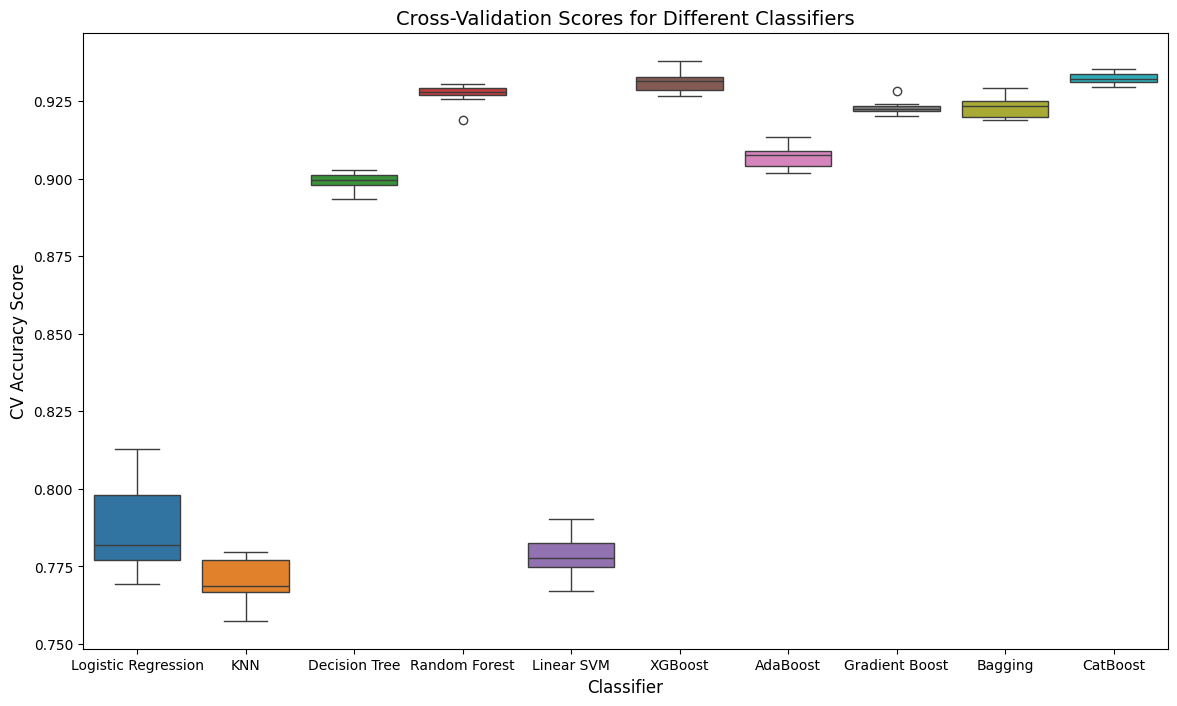

In [53]:
# Plot scores
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(cv_scores_df)

# Add axis labels
ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('CV Accuracy Score', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Classifiers', fontsize=14)

We can see the best performing model was Catboost by a small margin, followed by XGBoost. Worst performing was KNN.
Although Catboost received higher performance, let's continue with XGBoost as hyperparameter tuning is much faster.

# **5. Feature Engineering**
Let's take a look at the distributions of our numerical features to see if we could potentially improve the performance of our models by transforming any existing features. Let's kick off by creating histograms for each of the numerical features.

Whoops, let's first remove our already removed column 'age' from our list of numerical columns.

In [54]:
numerical_cols.remove('age')
numerical_cols

['income',
 'years_employed',
 'loan_interest_rate',
 'loan_percent_income',
 'credit_history',
 'credit_score',
 'loan_defaults']

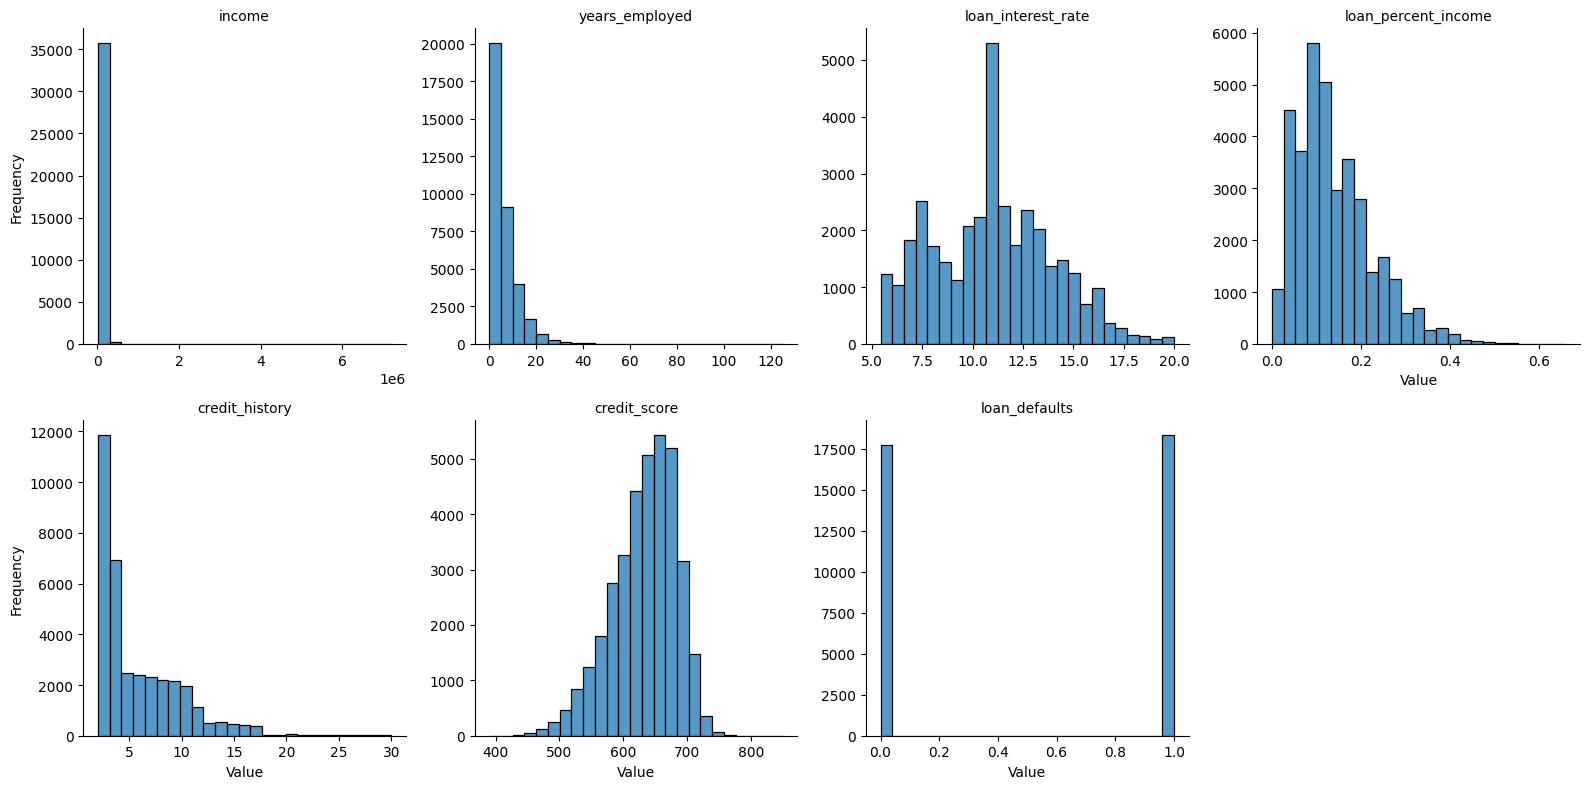

In [55]:
# Melt the DataFrame to long format
melted_X_train = X_train_df[numerical_cols].melt(var_name = 'Column', value_name = 'Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_X_train, col = 'Column', col_wrap = 4, sharex = False, sharey = False, height = 4)

# Map the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins = 25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template = '{col_name}')

plt.tight_layout()
plt.show()

Some of these features have a right skew. Let's declare troublesome columns to log transform them to reduce the skew.

In [56]:
# Define features we right skew
skewed_features = ['years_employed', 'loan_percent_income', 'credit_history']

# Define function to apply log transform
def log_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Apply the function to X_train
X_train_cleaned_log = log_of_feature(X_train_df, skewed_features)

Let's look at the distributions again to see if the log transform was effective at reducing the right skews.

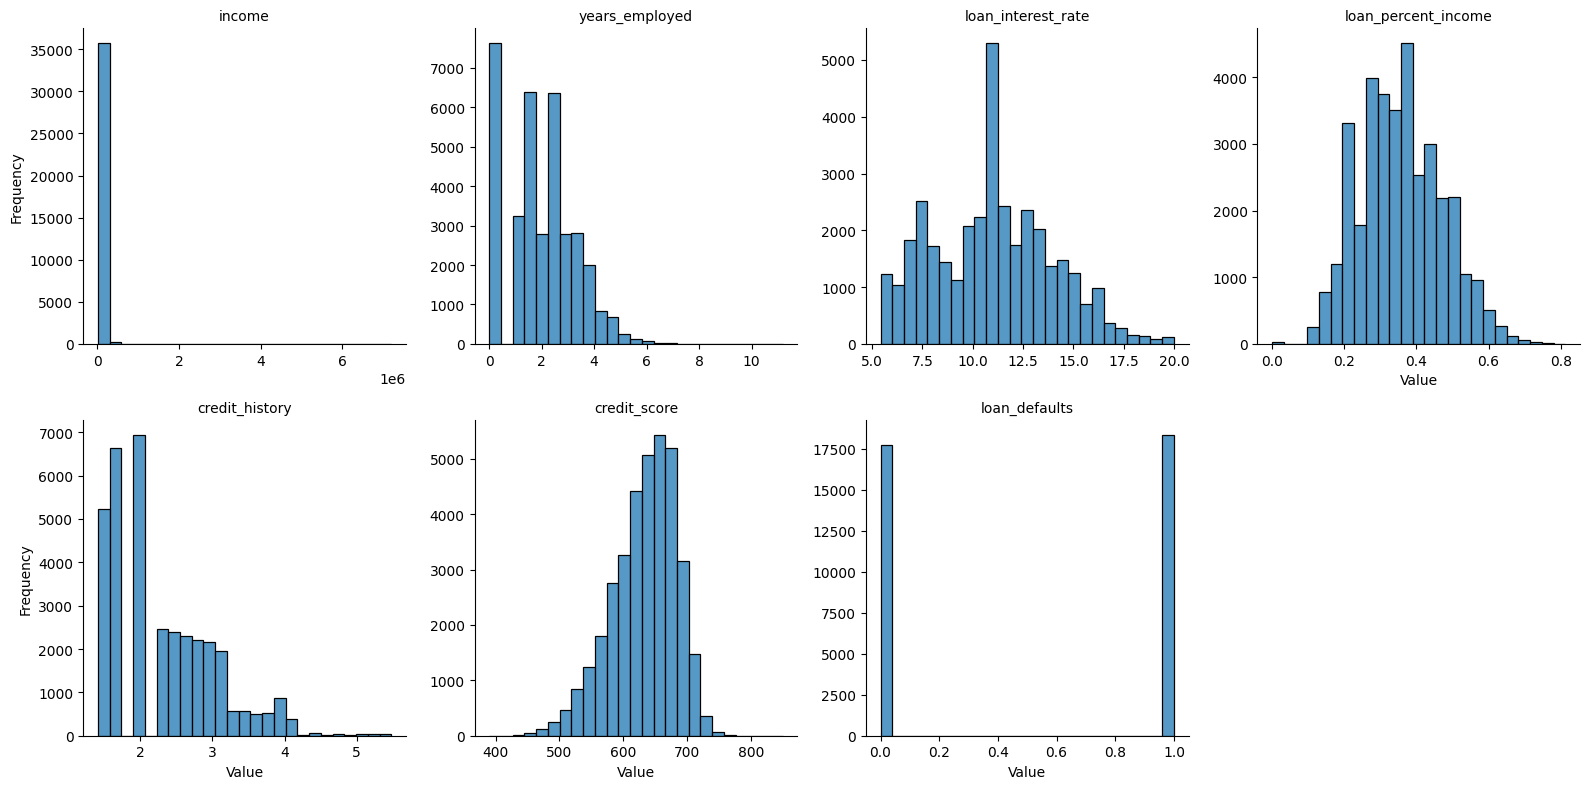

In [57]:
melted_X_train = X_train_cleaned_log[numerical_cols].melt(var_name='Column', value_name='Value')
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', bins=25)
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')
plt.tight_layout()
plt.show()

The skews have been reduced, let's see if our performance improved.

In [58]:
xgb_boost_clf = XGBClassifier(random_state = 14)

cv_scores = cross_val_score(xgb_boost_clf, X_train_df, y_train, cv = kf)
cv_scores_log = cross_val_score(xgb_boost_clf, X_train_cleaned_log, y_train, cv = kf)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_log.mean()}')

CV score without log transform: 0.93125
CV score with log transform: 0.93125


It's clear our log transform made no impact in improving base score, this is often to be expected with boosting models as they are less sensitive to skew and scale than other types of models.

### **5.1 Feature Scaling**
Now let's check if scaling our numerical features has any impact on model performance.

In [59]:
# Define function to scale numeric features
def scale_features(data_df, numeric_features):
    data = data_df.copy()

    # Initialise scaler
    scaler = StandardScaler()

    # Fit scaler to training data
    scaler.fit(data[numeric_features])

    # Transform numeric features
    data[numeric_features] = scaler.transform(data[numeric_features])
    return data

# Apply the function to X_train
X_train_cleaned_scaled = scale_features(X_train_cleaned_log, numerical_cols)

In [60]:
xgb_boost_clf = XGBClassifier(random_state=14)

cv_scores = cross_val_score(xgb_boost_clf, X_train_df, y_train, cv=kf)
cv_scores_scaled = cross_val_score(xgb_boost_clf, X_train_cleaned_scaled, y_train, cv=kf)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_scaled.mean()}')

CV score without log transform: 0.93125
CV score with log transform: 0.93125


Scaling made no impact on the base score. Let's continue.

In [61]:
X_train_clean = X_train_cleaned_scaled.copy()

# **6. Model Pipeline**
### **6.1 Custom Transformers**
As we want to drop the unwanted columns, we'll create a custom transformer to do this that we can use in our pipeline.

In [62]:
# Custom transformer to drop specified columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)

    def get_feature_names_out(self, input_features=None):
        return None

In [63]:
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.columns_to_transform] = np.sqrt(X[self.columns_to_transform])
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features

### **6.2 Pipelines**
We can now define the pipelines for each of data/encoding types.

In [64]:
from sklearn import set_config

# Set transformer output to df so we can reference columns names
set_config(transform_output='pandas')

In [73]:
cols_dropped.append('age')

In [80]:
numerical_cols

['income',
 'years_employed',
 'loan_interest_rate',
 'loan_percent_income',
 'credit_history',
 'credit_score',
 'loan_defaults']

In [95]:
# Define column dropper pipeline
cols_to_drop_pipeline = Pipeline([
    ('col_dropper', ColumnDropper(cols_dropped))
])

skewed_features = ['years_employed', 'loan_percent_income', 'credit_history']

# Define rank of education levels
education_rank = [['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']]

# Define ordinal categorical feature pipeline (highest_education feature)
cat_ord_pipeline = Pipeline([
    ('ord_encoder', OrdinalEncoder(categories = education_rank)),
])

# Define one-hot categorical feature pipeline
cat_one_hot_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')),
])

# Define numerical feature pipeline
num_pipeline = Pipeline([
    ('sqrt', SqrtTransformer(skewed_features)),
    ('scaler', StandardScaler()),
])

# Define preprocessing pipeline with a column transformer
preprocess_pipeline = ColumnTransformer([
    ('cat_ord', cat_ord_pipeline, cat_cols_ord),
    ('cat_one_hot', cat_one_hot_pipeline, cat_cols_onehot),
    ('drop_features', cols_to_drop_pipeline, cols_dropped),
    ('num', num_pipeline, numerical_cols),
])

We can now transform the raw X_train dataset with the pipeline.

In [119]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

We've succesfully transformed our data using our pipeline

# **7. Hyperparameter Optimisation**
### **Random Search**
To cover a large parameter space, we'll first use RandomSearchCV with random values from a defined range. We can then focus in on a smaller range of values with GridSearchCV

In [120]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': randint(low=50, high=300),
    'learning_rate':uniform(0.01, 0.29),
    'max_depth': randint(low=1, high = 20),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
    'min_child_weight': randint(low=1, high= 20),
    'reg_alpha': randint(low=0, high=100),
    'reg_lambda':randint(low=0, high=10),
    'gamma': uniform(0, 1),
}

# Initialize XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=2000, # Increased number of iterations
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [121]:
# Fit the model using RandomizedSearchCV
random_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best parameters found:  {'colsample_bytree': np.float64(0.9039020062837214), 'gamma': np.float64(0.044344212562339225), 'learning_rate': np.float64(0.10350796853682452), 'max_depth': 8, 'min_child_weight': 15, 'n_estimators': 254, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': np.float64(0.8822124118173135)}
Best cross-validation score:  0.9313296445414501


### **7.2 Grid Search**
We now have the best parameter values from our Random Search. As we've reduced the parameter space, we can now use Grid Search to check parameter combinations within the reduced grid space.

In [125]:
# Define the parameter grid with expanded ranges
xgb_param_grid_grid_search = {
    'n_estimators': [245, 255, 265],
    'max_depth': [7, 8, 9],
    'learning_rate': [0.09, 0.1, 0.11],
    'subsample': [0.85, 0.88, 0.91],
    'colsample_bytree': [0.85, 0.9, 0.95],
    'gamma': [0.03, 0.04, 0.05],
    'min_child_weight': [15],
    'reg_alpha': [0],
    'reg_lambda': [5],
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=14, eval_metric='error')

# Set up GridSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid_grid_search,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [129]:
# Fit the model using GridSearchCV
grid_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.9, 'gamma': 0.05, 'learning_rate': 0.11, 'max_depth': 9, 'min_child_weight': 15, 'n_estimators': 245, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.91}
Best cross-validation score:  0.931886521545738


We not have the best result from grid search. Let's compare both default and tuned models.

In [130]:
print(f'XGBoost model score (default hyperparameters): {cv_scores.mean()}')
print(f'XGBoost model score (tuned hyperparamters: {grid_search.best_score_}')

XGBoost model score (default hyperparameters): 0.93125
XGBoost model score (tuned hyperparamters: 0.931886521545738


We've seen 0.5% improvement with our tuned model

# **8. Model Evaluation**
It's now time to test the model with our test set.

In [131]:
# Prepare test set using pipeline
X_test_prepared = preprocess_pipeline.fit_transform(X_test)

# Predict the y_test values using the best model from the grid search
y_pred = grid_search.best_estimator_.predict(X_test_prepared)

Let's check f1 score of our test set predictions:

In [132]:
f1_score(y_test, y_pred, average = 'weighted')

0.9058496525849123

Let's create a confusion matrix for our model with the results of the test set to better understand it's performance.

Text(0.5, 1.0, 'Confusion Matrix on Training Data')

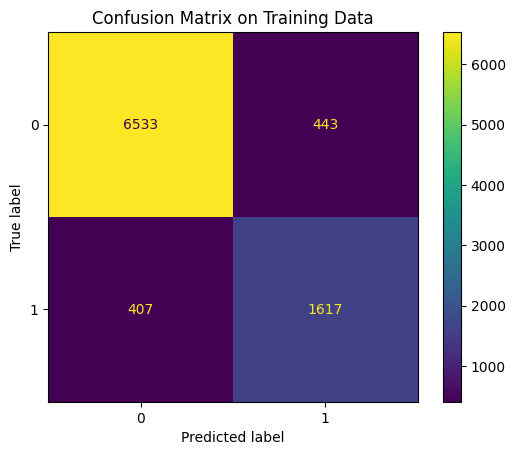

In [133]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix on Training Data')